<div style="font-size:37px; font-weight:bold; line-height:1.1">
    DInSAR simulator: Topographic components
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
This work has been created in projects supported by the US National Science Foundation and NASA (PI: Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook explores the simulation of the topographic components of an interferogram from a given topography. The simulation is done by mimicking the scene that leads to record an interferogram: a satellite passes over an area, sends a radar wave to the ground, and record the reflected signal. By doing so two times, or with another receiver away from the transmitter on the satellite, we get a difference in phase between the emitted and received signals due to a different look angle and a potential change in topography. This phase difference gives us the interferogram.

<img src="http://www.ga.gov.au/__data/assets/image/0008/22859/13-7402-1-sml1.jpg" width="800" align="left"/>
<div style="clear: left">
   Image source: [Commonwealth of Australia (Geoscience Australia)](http://www.ga.gov.au/scientific-topics/positioning-navigation/geodesy/geodetic-techniques/interferometric-synthetic-aperture-radar); image license: Creative Commons, [http://www.ga.gov.au/copyright](http://www.ga.gov.au/copyright)
</div>

In term of topography, interferograms are used to obtain height values over a given area and compute digital elevation models. Being able to simulate synthetic interferograms can help to improve the algorithms extracting the height.

# Package imports

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from getpass import getpass

from pyinsar.data_import.import_georaster import *
from pyinsar.output.export_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.processing.geography.geodesy import *
from pyinsar.processing.utilities.insar_simulator_utils import *

# Scene definition

Let's first get some topography from the Shuttle Radar Topography Mission (SRTM). You need an [Earthdata](https://earthdata.nasa.gov/) account to recover the data from NASA repositories. Then, you can enter you login and password there:

In [2]:
username = 'grongier'
password = getpass()

········


The area we will be using is near the Ötztal, an alpine valley in Austria. First, we need the corresponding tile from the SRTM data.

In [3]:
lon_min = 10 # degree
lon_max = 11 # degree
lat_min = 46 # degree
lat_max = 47 # degree

In [4]:
srtm_df = SRTM_DF(lat_tile_start = lat_min, lat_tile_end = lat_max - 1,
                  lon_tile_start = lon_min, lon_tile_end = lon_max - 1,
                  username = username, password = password)
srtm_tile = srtm_df.output()
topography = srtm_tile.data[list(srtm_tile.data.keys())[0]]

master_width = topography.shape[1]
master_height = topography.shape[0]
pixel_lon_size = (lon_max - lon_min)/(master_width - 1)
pixel_lat_size = (lat_max - lat_min)/(master_height - 1)
master_extent = (lon_min - 0.5*pixel_lon_size,
                 lon_max + 0.5*pixel_lon_size,
                 lat_min - 0.5*pixel_lat_size,
                 lat_max + 0.5*pixel_lat_size)
master_extent = (lon_min, lon_max, lat_min, lat_max)

100%|██████████| 2/2 [00:09<00:00,  6.34s/it]


Then, we focus on a more local area South of the valley.

In [5]:
lon_min = 10.77 # degree
lon_max = 10.95 # degree
lat_min = 46.76 # degree
lat_max = 46.86 # degree

In [6]:
topography, master_extent = extract_subgeoarray(topography,
                                                master_extent,
                                                lon_min, lon_max,
                                                lat_min, lat_max)
master_width = topography.shape[1]
master_height = topography.shape[0]

Now that we have the topography, we define the satellite location relative to the image and the satellite's characteristics. Here we use values close to those of the SRTM mission. The location of the second receiver is defined in relation to the first one through the baseline and alpha:

<img src="InSAR_Principle.png" width="600" align="left"/>
<div style="clear: left">
</div>

For the SRTM mission, the shuttle was equiped with two receivers, which aquired the phases in a single pass (hence k = 1). 

In [7]:
track_angle = 45. # degree
is_right_looking = False

min_ground_range = 225000. # meter
satellite_height = 230000. # meter

baseline = 60. # meter
alpha = 45. # degree

wavelength = 0.031 # meter

k = 1

In [8]:
rad_track_angle = track_angle*np.pi/180.
rad_alpha = alpha*np.pi/180.

# Computation of a synthetic interferogram using a projected Earth

Projecting the topography into a flat reference frame leads to simpler calculation. It also leads to approximations which can be problematic when covering a large area. First, we create a GDAL raster from the topography.

In [9]:
geotransform = (lon_min, (lon_max - lon_min)/master_width, 0.,
                lat_max, 0., (lat_min - lat_max)/master_height)
projection = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

# astype(np.float64) needed, otherwise the array is corrupt when saved
topography_raster = create_georaster_from_array(topography.astype(np.float64),           
                                                geotransform, 
                                                projection)

Then, we reproject the topography into a local reference frame, with the geographical coordinates defined in meter instead of degree (i.e., longitude and latitude).

In [10]:
grid_yx_spacing = (30., 30.) # meter

projected_topography_raster = reproject_georaster(topography_raster, grid_yx_spacing, new_projection_EPSG = 31258)
print_georaster_info(projected_topography_raster)
projected_topography = get_georaster_array(projected_topography_raster)

projected_extent_meter = get_georaster_extent(projected_topography_raster)
projected_extent = (projected_extent_meter[0]/1000.,
                    projected_extent_meter[1]/1000.,
                    projected_extent_meter[2]/1000.,
                    projected_extent_meter[3]/1000.)
projected_width = projected_topography.shape[1]
projected_height = projected_topography.shape[0]

Driver:  MEM / In Memory Raster
Size of the cube is  446 x 384 x 1
Projection is  PROJCS["MGI / Austria GK M31",GEOGCS["MGI",DATUM["Militar_Geographische_Institute",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],TOWGS84[577.326,90.129,463.919,5.137,1.474,5.297,2.4232],AUTHORITY["EPSG","6312"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4312"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",13.33333333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",450000],PARAMETER["false_northing",-5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","31258"]]
Origin = ( 254590.85422979158 , 194403.00409304537 )
Pixel Size = ( 30.0 , -30.0 )


<IPython.core.display.Javascript object>


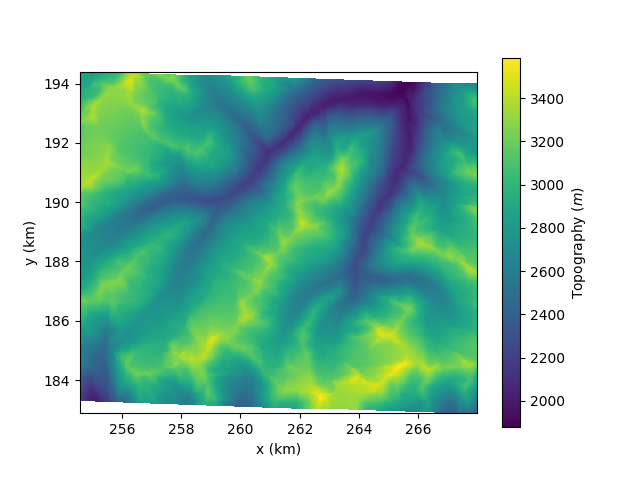

In [11]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(projected_topography), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Topography ($m$)')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

We define two arrays for the projected coordinate system.

In [12]:
xx, yy = compute_x_and_y_coordinates_maps(projected_extent_meter[0], projected_extent_meter[1], 
                                          projected_extent_meter[2], projected_extent_meter[3], 
                                          projected_width, projected_height)

And now we can compute the horizontal distance (i.e., the ground range) from any cell of the study area to the satellite for the first receiver.

In [13]:
cross_track_distance = xx*math.cos(rad_track_angle) - yy*math.sin(rad_track_angle)
if is_right_looking == False:
    cross_track_distance *= -1.
cross_track_distance -= cross_track_distance.min()

ground_range = cross_track_distance + min_ground_range
ground_range[np.isnan(projected_topography)] = np.nan

## Based on the geometry between the two receivers

To compute a synthetic interferogram, we need the actual distances between a cell and the satellite (i.e., a slant range) for the two receivers. We can first do that based on the geometry of the scene, using the law of cosines. 

In [14]:
topographic_range = np.sqrt(ground_range**2 + projected_topography**2)
rad_topographic_angle = np.arctan(projected_topography/ground_range)
slant_range_1 = np.sqrt(satellite_height**2 + topographic_range**2 - 2.*satellite_height*topographic_range*np.cos(np.pi/2. - rad_topographic_angle))

rad_look_angle_1 = np.arccos((satellite_height**2 + slant_range_1**2 - topographic_range**2)/(2.*satellite_height*slant_range_1))
rad_alpha_range = np.pi/2. - rad_look_angle_1 + rad_alpha
slant_range_2 = np.sqrt(slant_range_1**2 + baseline**2 - 2.*slant_range_1*baseline*np.cos(rad_alpha_range))

<IPython.core.display.Javascript object>


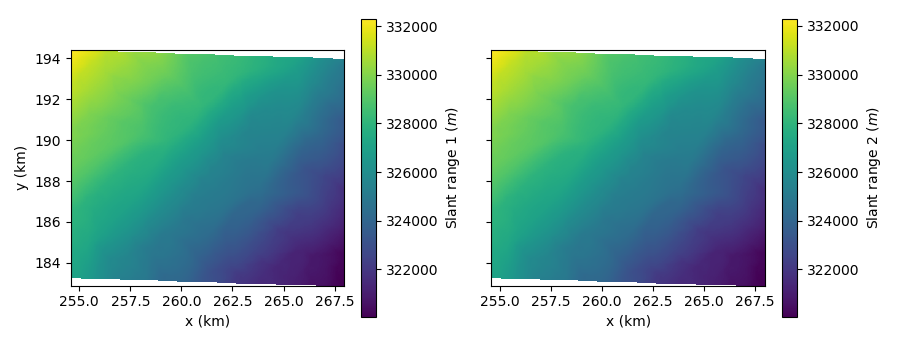

In [15]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

map_1 = subplot1.imshow(np.ma.masked_invalid(slant_range_1), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
map_1_colorbar = plt.colorbar(map_1, ax = subplot1)
map_1_colorbar.set_label('Slant range 1 ($m$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

map_2 = subplot2.imshow(np.ma.masked_invalid(slant_range_2), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = subplot2)
map_2_colorbar.set_label('Slant range 2 ($m$)')
subplot2.set_xlabel('x (km)')

plt.tight_layout()

plt.show()

To obtain an interferogram, we just need to turn the difference of the slant ranges from meters to degrees, using the satellite's wavelength, and then wrap the result between -&pi; and &pi;. The wrapping actually creates the fringes of the interferogram.

In [16]:
interferogram = wrap(-2.*np.pi*k*(slant_range_1 - slant_range_2)/wavelength)

We can also compute the slant ranges for different components. For instance, we can compute the component to remove from the interferogram if we want to recover the topography from the fringes.

In [17]:
slant_range_1_flat_earth = slant_range_1

rad_look_angle_1_flat_earth = np.arccos(satellite_height/slant_range_1_flat_earth)
rad_alpha_range_flat_earth = np.pi/2. - rad_look_angle_1_flat_earth + rad_alpha
slant_range_2_flat_earth = np.sqrt(slant_range_1_flat_earth**2 + baseline**2
                                   - 2.*slant_range_1_flat_earth*baseline*np.cos(rad_alpha_range_flat_earth))

In [18]:
interferogram_flat_earth = wrap(-2.*np.pi*k*(slant_range_1_flat_earth - slant_range_2_flat_earth)/wavelength)

In [19]:
interferogram_topo = wrap(interferogram - interferogram_flat_earth)

In [20]:
look_angle_0 = np.arccos(satellite_height/slant_range_1)
baseline_perpendicular = baseline*np.cos(look_angle_0 - rad_alpha)

delta_range_far_field = baseline_perpendicular*projected_topography/(slant_range_1*np.sin(look_angle_0))
interferogram_far_field = wrap(-2.*np.pi*k*delta_range_far_field/wavelength)

<IPython.core.display.Javascript object>


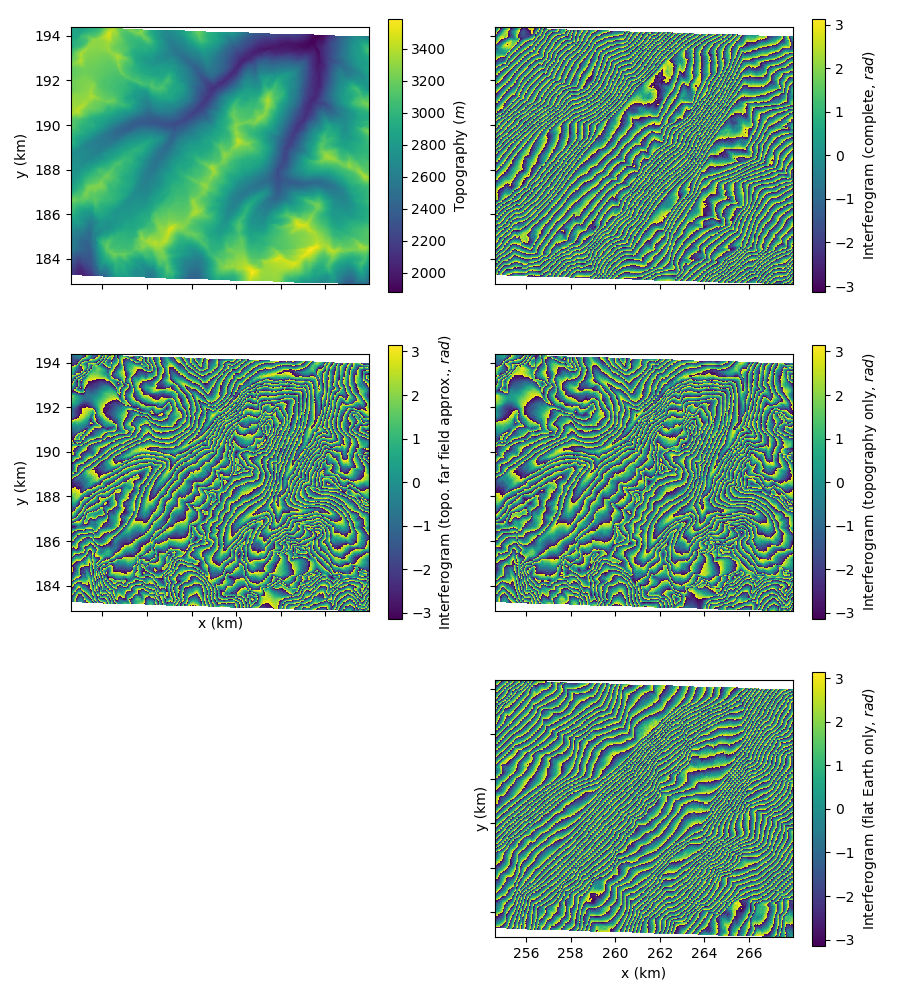

In [21]:
figure, subplots = plt.subplots(3, 2, sharex = True, sharey = True, figsize = (9, 10))

map_1 = subplots[0, 0].imshow(np.ma.masked_invalid(projected_topography), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_1_colorbar = plt.colorbar(map_1, ax = subplots[0, 0])
map_1_colorbar.set_label('Topography ($m$)')
subplots[0, 0].set_ylabel('y (km)')

map_2 = subplots[0, 1].imshow(np.ma.masked_invalid(interferogram), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = subplots[0, 1])
map_2_colorbar.set_label('Interferogram (complete, $rad$)')
subplots[1, 0].set_xlabel('x (km)')
subplots[1, 0].set_ylabel('y (km)')

map_3 = subplots[1, 0].imshow(np.ma.masked_invalid(interferogram_far_field), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_3_colorbar = plt.colorbar(map_3, ax = subplots[1, 0])
map_3_colorbar.set_label('Interferogram (topo. far field approx., $rad$)')

map_4 = subplots[1, 1].imshow(np.ma.masked_invalid(interferogram_topo), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_4_colorbar = plt.colorbar(map_4, ax = subplots[1, 1])
map_4_colorbar.set_label('Interferogram (topography only, $rad$)')

subplots[2, 0].axis('off')

map_5 = subplots[2, 1].imshow(np.ma.masked_invalid(interferogram_flat_earth), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_5_colorbar = plt.colorbar(map_5, ax = subplots[2, 1])
map_5_colorbar.set_label('Interferogram (flat Earth only, $rad$)')
subplots[2, 1].set_xlabel('x (km)')
subplots[2, 1].set_ylabel('y (km)')

plt.tight_layout()

plt.show()

The so-called flat-Earth component still contains some topographic component. Here, we can compute the actual flat-Earth and topographic components.

In [22]:
slant_range_1_real_flat_earth = np.sqrt(satellite_height**2 + ground_range**2)
rad_look_angle_1_real_flat_earth = np.arccos(satellite_height/slant_range_1_real_flat_earth)
rad_alpha_range_real_flat_earth = np.pi/2. - rad_look_angle_1_real_flat_earth + rad_alpha
slant_range_2_real_flat_earth = np.sqrt(slant_range_1_real_flat_earth**2 + baseline**2
                                        - 2.*slant_range_1_real_flat_earth*baseline*np.cos(rad_alpha_range_real_flat_earth))

In [23]:
interferogram_real_flat_earth = wrap(-2.*np.pi*k*(slant_range_1_real_flat_earth - slant_range_2_real_flat_earth)/wavelength)

In [24]:
interferogram_flat_earth_topo = wrap(interferogram_flat_earth - interferogram_real_flat_earth)

In [25]:
interferogram_real_topo = wrap(interferogram - interferogram_real_flat_earth)

In [26]:
interferogram_reconstituted_topo = wrap(interferogram_topo + interferogram_flat_earth_topo)

<IPython.core.display.Javascript object>


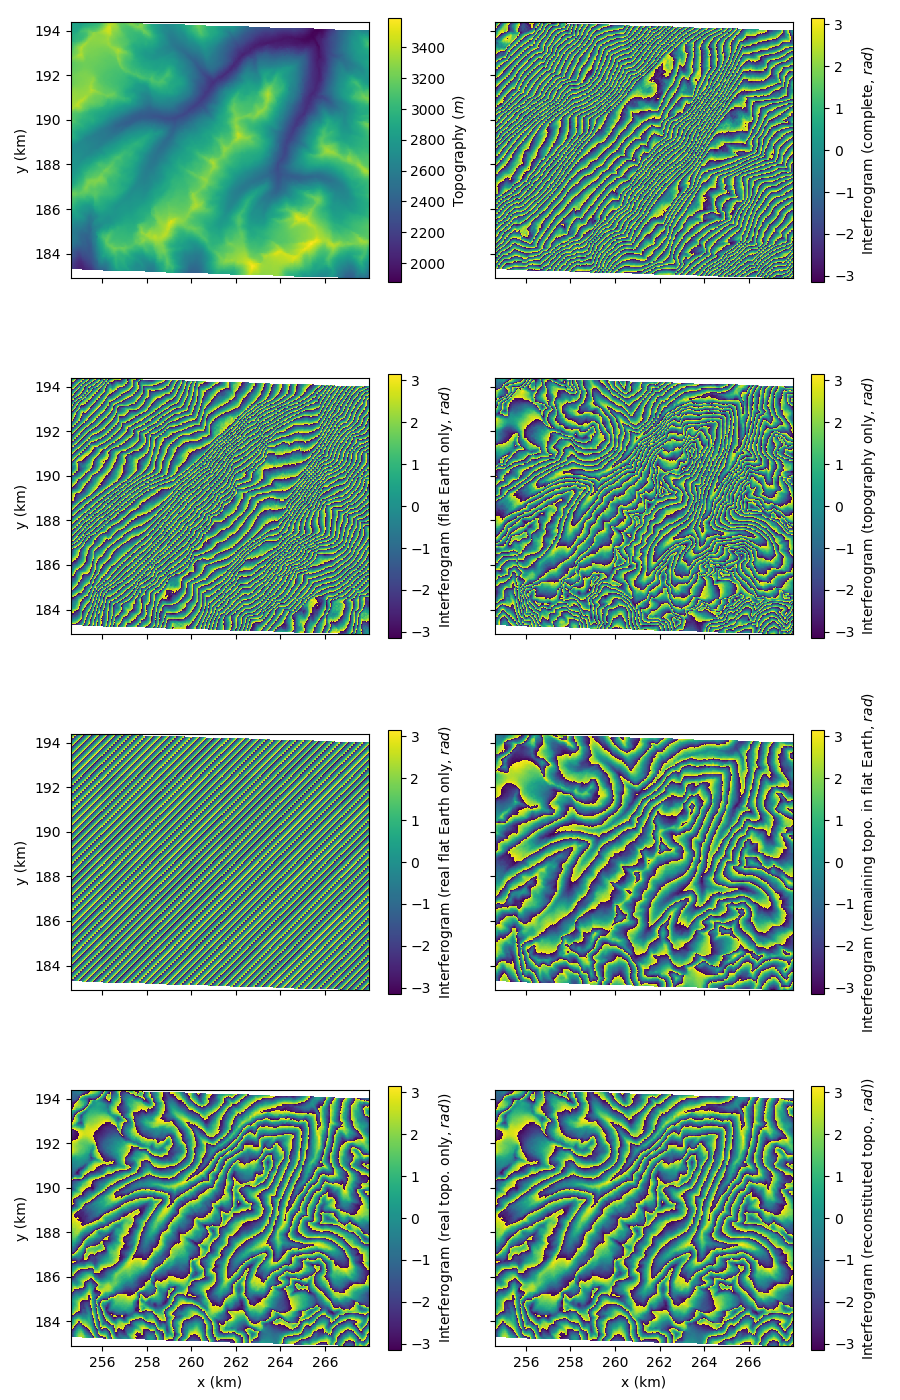

In [27]:
figure, subplots = plt.subplots(4, 2, sharex = True, sharey = True, figsize = (9, 14))

map_1 = subplots[0, 0].imshow(np.ma.masked_invalid(projected_topography),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_1_colorbar = plt.colorbar(map_1, ax = subplots[0, 0])
map_1_colorbar.set_label('Topography ($m$)')
subplots[0, 0].set_ylabel('y (km)')

map_2 = subplots[0, 1].imshow(np.ma.masked_invalid(interferogram),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = subplots[0, 1])
map_2_colorbar.set_label('Interferogram (complete, $rad$)')
subplots[1, 0].set_ylabel('y (km)')

map_3 = subplots[1, 0].imshow(np.ma.masked_invalid(interferogram_flat_earth),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_3_colorbar = plt.colorbar(map_3, ax = subplots[1, 0])
map_3_colorbar.set_label('Interferogram (flat Earth only, $rad$)')

map_4 = subplots[1, 1].imshow(np.ma.masked_invalid(interferogram_topo), 
                                    extent = projected_extent,
                                    cmap = 'viridis', interpolation = 'None', rasterized = True,
                                    zorder = 0)
map_4_colorbar = plt.colorbar(map_4, ax = subplots[1, 1])
map_4_colorbar.set_label('Interferogram (topography only, $rad$)')

map_5 = subplots[2, 0].imshow(np.ma.masked_invalid(interferogram_real_flat_earth),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_5_colorbar = plt.colorbar(map_5, ax = subplots[2, 0])
map_5_colorbar.set_label('Interferogram (real flat Earth only, $rad$)')
subplots[2, 0].set_ylabel('y (km)')

map_6 = subplots[2, 1].imshow(np.ma.masked_invalid(interferogram_flat_earth_topo),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_6_colorbar = plt.colorbar(map_6, ax = subplots[2, 1])
map_6_colorbar.set_label('Interferogram (remaining topo. in flat Earth, $rad$)')

map_7 = subplots[3, 0].imshow(np.ma.masked_invalid(interferogram_real_topo),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_7_colorbar = plt.colorbar(map_7, ax = subplots[3, 0])
map_7_colorbar.set_label('Interferogram (real topo. only, $rad$))')
subplots[3, 0].set_xlabel('x (km)')
subplots[3, 0].set_ylabel('y (km)')

map_8 = subplots[3, 1].imshow(np.ma.masked_invalid(interferogram_reconstituted_topo),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
map_8_colorbar = plt.colorbar(map_8, ax = subplots[3, 1])
map_8_colorbar.set_label('Interferogram (reconstituted topo., $rad$))')
subplots[3, 1].set_xlabel('x (km)')

plt.tight_layout()

plt.show()

## Based on the receiver's geographic coordinates

Another way to compute a synthetic interferogram consists in determining the actual coordinates of the receivers in the projected reference frame.

In [28]:
baseline_horizontal = baseline*math.cos(rad_alpha)
baseline_vertical = baseline*math.sin(rad_alpha)

horizontal_incidence_vector = np.array([-math.cos(rad_track_angle),
                                        math.sin(rad_track_angle)])
if is_right_looking == False:
    horizontal_incidence_vector *= -1.

In [29]:
satellite_xx_1 = xx + ground_range*horizontal_incidence_vector[0]
satellite_yy_1 = yy + ground_range*horizontal_incidence_vector[1]

In [30]:
satellite_xx_2 = satellite_xx_1 - baseline_horizontal*horizontal_incidence_vector[0]
satellite_yy_2 = satellite_yy_1 - baseline_horizontal*horizontal_incidence_vector[1]
satellite_height_2 = satellite_height + baseline_vertical

Then, the slant range is just the Euclidean distance between the satellite and the topography.

In [31]:
slant_range_1 = np.sqrt((xx - satellite_xx_1)**2 + (yy - satellite_yy_1)**2 + (projected_topography - satellite_height)**2)
slant_range_2 = np.sqrt((xx - satellite_xx_2)**2 + (yy - satellite_yy_2)**2 + (projected_topography - satellite_height_2)**2)

In [32]:
interferogram_from_coordinates = wrap(-2.*np.pi*k*(slant_range_1 - slant_range_2)/wavelength)

<IPython.core.display.Javascript object>


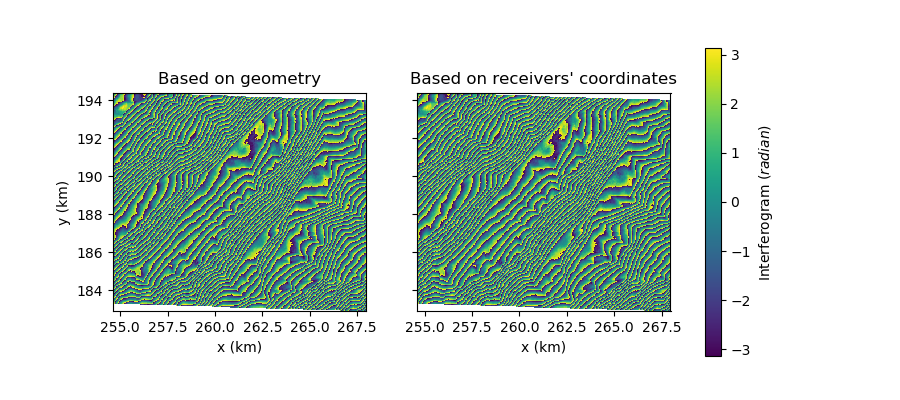

In [33]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

map_1 = subplot1.imshow(np.ma.masked_invalid(interferogram), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')
subplot1.set_title('Based on geometry')

map_2 = subplot2.imshow(np.ma.masked_invalid(interferogram_from_coordinates), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = (subplot1, subplot2))
map_2_colorbar.set_label('Interferogram ($radian$)')
subplot2.set_xlabel('x (km)')
subplot2.set_title("Based on receivers' coordinates")

plt.show()

# Computation of a synthetic interferogram using a spherical Earth

Another approach consists in avoiding the projection, to obtain better results when dealing with large areas. One common approximation is to rely on a spherical Earth, which decreases the errors without too much increase of the calculation complexity.

In [34]:
longitude, latitude = compute_x_and_y_coordinates_maps(lon_min, lon_max, 
                                                       lat_min, lat_max, 
                                                       master_width, master_height)
rad_longitude = longitude*np.pi/180.
rad_latitude = latitude*np.pi/180.

In [35]:
earth_radius = 6371008.8 # meter

Here, we focus on computing the satellite position. The same results can be obtained using geometrical relationships and the law of cosines, similarly to what we did in the previous section.

In [36]:
rad_origin_longitude = rad_longitude[0, 0]
rad_origin_latitude = rad_latitude[0, 0]
distance_to_origin, rad_bearing_from_origin = compute_great_circle_distance_and_bearing(rad_origin_longitude,
                                                                                        rad_origin_latitude,
                                                                                        rad_longitude,
                                                                                        rad_latitude,
                                                                                        earth_radius)

In [37]:
ground_range = np.arcsin(np.sin(distance_to_origin/earth_radius)*np.sin(rad_bearing_from_origin - rad_track_angle))*earth_radius
if is_right_looking == False:
    ground_range *= -1
ground_range -= np.nanmin(ground_range)
ground_range += min_ground_range

In [38]:
baseline_horizontal = baseline*math.cos(rad_alpha)
baseline_vertical = baseline*math.sin(rad_alpha)

look_orientation = 1.
if is_right_looking == False:
    look_orientation = -1.
rad_inv_look_azimuth = (rad_track_angle + look_orientation*np.pi/2. + np.pi)%(2.*np.pi)

The idea is to determine the longitudes and latitudes of the satellite along its track, and to convert them to a Cartesian reference frame with the center of the Earth as origin.

In [39]:
rad_satellite_longitude_1, rad_satellite_latitude_1 = compute_lonlat_from_distance_bearing(rad_longitude,
                                                                                           rad_latitude,
                                                                                           ground_range,
                                                                                           rad_inv_look_azimuth,
                                                                                           earth_radius)

satellite_xx_1 = (earth_radius + satellite_height)*np.cos(rad_satellite_latitude_1)*np.cos(rad_satellite_longitude_1)
satellite_yy_1 = (earth_radius + satellite_height)*np.cos(rad_satellite_latitude_1)*np.sin(rad_satellite_longitude_1)
satellite_zz_1 = (earth_radius + satellite_height)*np.sin(rad_satellite_latitude_1)

In [40]:
satellite_vector = (-np.sin(rad_alpha)*math.cos(rad_track_angle),
                    np.sin(rad_alpha)*math.sin(rad_track_angle))
rad_satellite_bearing = np.arctan2(satellite_vector[0], satellite_vector[1])

In [41]:
rad_satellite_longitude_2, rad_satellite_latitude_2 = compute_lonlat_from_distance_bearing(rad_satellite_longitude_1,
                                                                                           rad_satellite_latitude_1,
                                                                                           baseline_horizontal,
                                                                                           rad_satellite_bearing,
                                                                                           earth_radius)
satellite_height_2 = satellite_height + baseline_vertical

satellite_xx_2 = (earth_radius + satellite_height_2)*np.cos(rad_satellite_latitude_2)*np.cos(rad_satellite_longitude_2)
satellite_yy_2 = (earth_radius + satellite_height_2)*np.cos(rad_satellite_latitude_2)*np.sin(rad_satellite_longitude_2)
satellite_zz_2 = (earth_radius + satellite_height_2)*np.sin(rad_satellite_latitude_2)

The topography is also converted.

In [42]:
xx = (earth_radius + topography)*np.cos(rad_latitude)*np.cos(rad_longitude)
yy = (earth_radius + topography)*np.cos(rad_latitude)*np.sin(rad_longitude)
zz = (earth_radius + topography)*np.sin(rad_latitude)

In [43]:
slant_range_1 = np.sqrt((xx - satellite_xx_1)**2 + (yy - satellite_yy_1)**2 + (zz - satellite_zz_1)**2)
slant_range_2 = np.sqrt((xx - satellite_xx_2)**2 + (yy - satellite_yy_2)**2 + (zz - satellite_zz_2)**2)

Before wrapping the interferogram, we project the difference in slant range, to compare the interferogram using a spherical Earth and the one using a projected Earth.

In [44]:
interferogram_spherical_earth = -2.*np.pi*k*(slant_range_1 - slant_range_2)/wavelength

In [45]:
interferogram_raster = create_georaster_from_array(interferogram_spherical_earth,           
                                                   geotransform, 
                                                   projection)
projected_interferogram_raster = reproject_georaster(interferogram_raster, grid_yx_spacing, new_projection_EPSG = 31258)
print_georaster_info(projected_interferogram_raster)
projected_interferogram_spherical_earth = get_georaster_array(projected_interferogram_raster)
projected_interferogram_spherical_earth = wrap(projected_interferogram_spherical_earth)

Driver:  MEM / In Memory Raster
Size of the cube is  446 x 384 x 1
Projection is  PROJCS["MGI / Austria GK M31",GEOGCS["MGI",DATUM["Militar_Geographische_Institute",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],TOWGS84[577.326,90.129,463.919,5.137,1.474,5.297,2.4232],AUTHORITY["EPSG","6312"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4312"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",13.33333333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",450000],PARAMETER["false_northing",-5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","31258"]]
Origin = ( 254590.85422979158 , 194403.00409304537 )
Pixel Size = ( 30.0 , -30.0 )


<IPython.core.display.Javascript object>


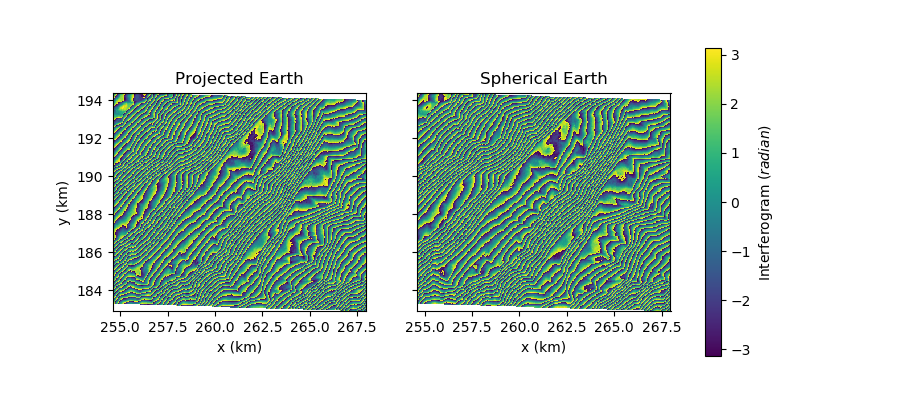

In [46]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

map_1 = subplot1.imshow(np.ma.masked_invalid(interferogram_from_coordinates), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')
subplot1.set_title('Projected Earth')

map_2 = subplot2.imshow(np.ma.masked_invalid(projected_interferogram_spherical_earth), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = (subplot1, subplot2))
map_2_colorbar.set_label('Interferogram ($radian$)')
subplot2.set_xlabel('x (km)')
subplot2.set_title('Spherical Earth')

plt.show()

# Computation of a synthetic interferogram using an ellipsoidal Earth

Earth is best approximated by an oblate ellipsoid than a sphere, so using an ellipsoidal Earth should lead to even fewer errors. However, geometry on an ellispoid is much more complicated than on a sphere. Most methods rely on optimization loops to find the best approximate solution.

In [47]:
wgs84_a = 6378137. # meter
wgs84_f = 1/298.257223563

wgs84_b = wgs84_a*(1 - wgs84_f)
sq_e = 1 - (wgs84_b/wgs84_a)**2

In [48]:
longitude, latitude = compute_x_and_y_coordinates_maps(lon_min, lon_max, 
                                                       lat_min, lat_max, 
                                                       master_width, master_height)
rad_longitude = longitude*np.pi/180.
rad_latitude = latitude*np.pi/180.

Among those methods [Vincenty's formulae](https://en.wikipedia.org/wiki/Vincenty%27s_formulae) provide enough accuracy. Finding the perpendicular distance between a point and a geodesic has received less attention so far, and the implementation used here can sometimes lead to errors on the order of a meter.

In [49]:
rad_origin_longitude = rad_longitude[0, 0]
rad_origin_latitude = rad_latitude[0, 0]
ground_range = compute_point_to_line_distance_for_array(rad_origin_longitude,
                                                        rad_origin_latitude,
                                                        rad_longitude,
                                                        rad_latitude,
                                                        rad_track_angle,
                                                        wgs84_a,
                                                        wgs84_f)
if is_right_looking == False:
    ground_range *= -1
ground_range -= np.nanmin(ground_range)
ground_range += min_ground_range

In [50]:
baseline_horizontal = baseline*math.cos(rad_alpha)
baseline_vertical = baseline*math.sin(rad_alpha)

look_orientation = 1.
if is_right_looking == False:
    look_orientation = -1.
rad_inv_look_azimuth = (rad_track_angle + look_orientation*np.pi/2. + np.pi)%(2.*np.pi)

The next steps are similar to those with a spherical Earth, i.e., conversion to a Cartesian reference frame for the satellite and the topography before computing the slant range for the two receivers.

In [51]:
rad_satellite_longitude_1, rad_satellite_latitude_1 = direct_vincenty_formula_for_array(rad_longitude,
                                                                                        rad_latitude,
                                                                                        ground_range,
                                                                                        rad_inv_look_azimuth,
                                                                                        wgs84_a,
                                                                                        wgs84_f)

radius_prime_vertical = wgs84_a/np.sqrt(1 - sq_e*np.sin(rad_satellite_latitude_1)**2)
satellite_xx_1 = (radius_prime_vertical + satellite_height)*np.cos(rad_satellite_latitude_1)*np.cos(rad_satellite_longitude_1)
satellite_yy_1 = (radius_prime_vertical + satellite_height)*np.cos(rad_satellite_latitude_1)*np.sin(rad_satellite_longitude_1)
satellite_zz_1 = (radius_prime_vertical*(1 - sq_e) + satellite_height)*np.sin(rad_satellite_latitude_1)

In [52]:
satellite_vector = (-np.sin(rad_alpha)*math.cos(rad_track_angle),
                    np.sin(rad_alpha)*math.sin(rad_track_angle))
rad_satellite_bearing = np.arctan2(satellite_vector[0], satellite_vector[1])

In [53]:
baseline_horizontal = np.full(ground_range.shape, baseline_horizontal)

rad_satellite_longitude_2, rad_satellite_latitude_2 = direct_vincenty_formula_for_array(rad_satellite_longitude_1,
                                                                                        rad_satellite_latitude_1,
                                                                                        baseline_horizontal,
                                                                                        rad_satellite_bearing,
                                                                                        wgs84_a,
                                                                                        wgs84_f)
satellite_height_2 = satellite_height + baseline_vertical

radius_prime_vertical = wgs84_a/np.sqrt(1 - sq_e*np.sin(rad_satellite_latitude_2)**2)
satellite_xx_2 = (radius_prime_vertical + satellite_height_2)*np.cos(rad_satellite_latitude_2)*np.cos(rad_satellite_longitude_2)
satellite_yy_2 = (radius_prime_vertical + satellite_height_2)*np.cos(rad_satellite_latitude_2)*np.sin(rad_satellite_longitude_2)
satellite_zz_2 = (radius_prime_vertical*(1 - sq_e) + satellite_height_2)*np.sin(rad_satellite_latitude_2)

In [54]:
radius_prime_vertical = wgs84_a/np.sqrt(1 - sq_e*np.sin(rad_latitude)**2)
xx = (radius_prime_vertical + topography)*np.cos(rad_latitude)*np.cos(rad_longitude)
yy = (radius_prime_vertical + topography)*np.cos(rad_latitude)*np.sin(rad_longitude)
zz = (radius_prime_vertical*(1 - sq_e) + topography)*np.sin(rad_latitude)

In [55]:
slant_range_1 = np.sqrt((xx - satellite_xx_1)**2 + (yy - satellite_yy_1)**2 + (zz - satellite_zz_1)**2)
slant_range_2 = np.sqrt((xx - satellite_xx_2)**2 + (yy - satellite_yy_2)**2 + (zz - satellite_zz_2)**2)

We can also project the new interferogram, and compare it with the previous ones.

In [56]:
interferogram_ellipsoidal_earth = -2.*np.pi*k*(slant_range_1 - slant_range_2)/wavelength

In [57]:
interferogram_raster = create_georaster_from_array(interferogram_ellipsoidal_earth,           
                                                   geotransform, 
                                                   projection)
projected_interferogram_raster = reproject_georaster(interferogram_raster, grid_yx_spacing, new_projection_EPSG = 31258)
print_georaster_info(projected_interferogram_raster)
projected_interferogram_ellipsoidal_earth = get_georaster_array(projected_interferogram_raster)
projected_interferogram_ellipsoidal_earth = wrap(projected_interferogram_ellipsoidal_earth)

Driver:  MEM / In Memory Raster
Size of the cube is  446 x 384 x 1
Projection is  PROJCS["MGI / Austria GK M31",GEOGCS["MGI",DATUM["Militar_Geographische_Institute",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],TOWGS84[577.326,90.129,463.919,5.137,1.474,5.297,2.4232],AUTHORITY["EPSG","6312"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4312"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",13.33333333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",450000],PARAMETER["false_northing",-5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","31258"]]
Origin = ( 254590.85422979158 , 194403.00409304537 )
Pixel Size = ( 30.0 , -30.0 )


<IPython.core.display.Javascript object>


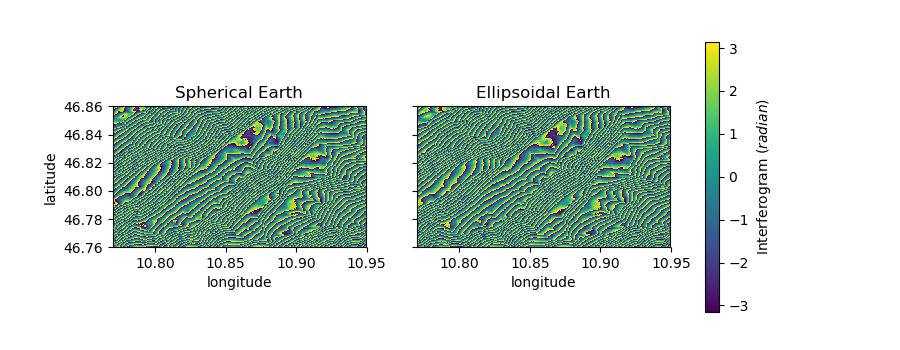

In [58]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

map_1 = subplot1.imshow(np.ma.masked_invalid(wrap(interferogram_spherical_earth)), extent = master_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
subplot1.set_xlabel('longitude')
subplot1.set_ylabel('latitude')
subplot1.set_title('Spherical Earth')

map_2 = subplot2.imshow(np.ma.masked_invalid(wrap(interferogram_ellipsoidal_earth)), extent = master_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
map_2_colorbar = plt.colorbar(map_2, ax = (subplot1, subplot2))
map_2_colorbar.set_label('Interferogram ($radian$)')
subplot2.set_xlabel('longitude')
subplot2.set_title('Ellipsoidal Earth')

plt.show()

<IPython.core.display.Javascript object>


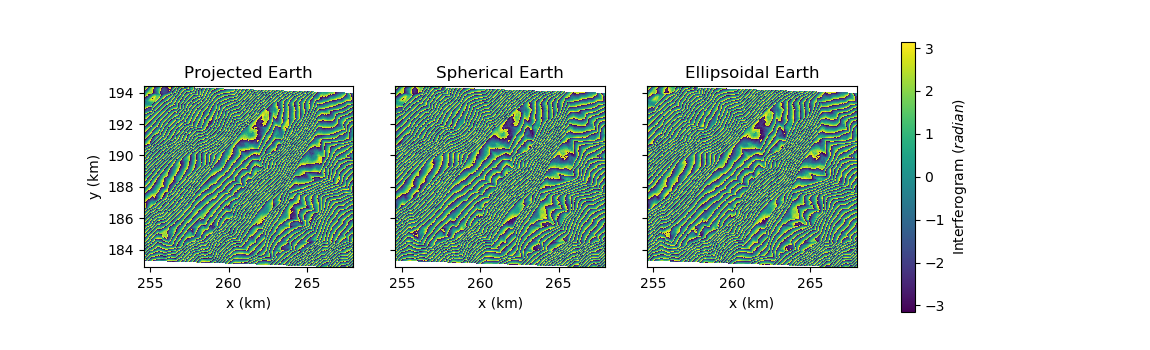

In [59]:
figure, subplots = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (11.5, 3.5))

map_1_map = subplots[0].imshow(np.ma.masked_invalid(interferogram_from_coordinates),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')
subplots[0].set_title('Projected Earth')

map_2_map = subplots[1].imshow(np.ma.masked_invalid(projected_interferogram_spherical_earth),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
subplots[1].set_xlabel('x (km)')
subplots[1].set_title('Spherical Earth')

map_3_map = subplots[2].imshow(np.ma.masked_invalid(projected_interferogram_ellipsoidal_earth),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
map_3_colorbar = plt.colorbar(map_3_map, ax = subplots.ravel().tolist())
map_3_colorbar.set_label('Interferogram ($radian$)')
subplots[2].set_xlabel('x (km)')
subplots[2].set_title('Ellipsoidal Earth')

plt.show()